In [5]:
import matplotlib.pyplot as plt
import pickle
from DataLoader import DataLoader
from Factors import FactorFunc, FactorCalculator
from ModelTraining import Trainer
from DefaultModel import DefaultModel

In [2]:
%matplotlib inline

In [ ]:
# Download StockCodes
# Load the list of stock codes
# This function retrieves all the stock codes that will be used in the analysis
StockCodes = DataLoader.load_stock_codes()

In [ ]:
# Initialize DataLoader
# This creates a new DataLoader object with the list of stock codes, start date, and end date
# The DataLoader class is defined in DataLoader.py and handles data loading and preprocessing
Loader = DataLoader(StockCodes, start_date='2002-01-01', end_date='2024-07-31')

# Load Spot Price
# This calls the load_spot_prices method of the DataLoader class
# It retrieves the spot prices for all the specified stock codes within the date range
Loader.load_spot_prices()

# Load Adjusted Price
# This calls the load_adjusted_price method of the DataLoader class
# It retrieves the adjusted prices (accounting for splits, dividends, etc.) for all the specified stock codes
Loader.load_adjusted_price()

# Load Index Price
# This calls the load_index method of the DataLoader class
# It retrieves the index prices for the market index (e.g., S&P 500) within the specified date range
Loader.load_index()

In [ ]:
# Retrieve the stock data from the Loader object
StockDict = Loader.stock_data

# Retrieve the index data from the Loader object
IndexDict = Loader.index_data

# Note: These lines create dictionaries containing the loaded stock and index data
# StockDict will contain individual stock data for all the stocks loaded
# IndexDict will contain data for the market index (e.g., S&P 500)
# These dictionaries will be used for further analysis and factor calculations

In [ ]:
# Initialize Factor Handler
# This creates a new FactorCalculator object with the StockDict containing stock data
# The FactorCalculator class is likely defined in Factors.py and handles factor calculations
# It will be used to create various factors based on the stock data
Calculator = FactorCalculator(StockDict)

# Note: The FactorCalculator is initialized with StockDict, which contains the loaded stock data
# This object will be used to calculate various factors such as returns, volatility, and IVOL
# as seen in the FactorFunc class in Factors.py

In [ ]:
# Create Some Features

# Note: The following code creates various factors using the FactorCalculator.
# Some factors have been omitted to achieve the performance of the subsequent model.
# Users can define their own factors in the FactorFunc class for customization.

# Calculate daily returns for stocks and index
Calculator.create_factor(factor_func=FactorFunc.rets,base_col = 'ADJCLOSE', target_col = 'DAYRET')
Calculator.create_factor(factor_func=FactorFunc.rets,base_col = 'IDXCLOSE', target_col = 'IDXRET')

# Calculate Realized Volatility Factors
# These factors measure the volatility of returns over different time windows
Calculator.create_factor(factor_func=FactorFunc.volatility, base_col = 'DAYRET',
                         target_col = 'RV5', window = 5)
Calculator.create_factor(factor_func=FactorFunc.volatility, base_col = 'DAYRET',
                         target_col = 'RV10', window = 10)
Calculator.create_factor(factor_func=FactorFunc.volatility, base_col = 'DAYRET',
                         target_col = 'RV20', window = 20)

# Additional factors have been omitted here for brevity and performance optimization.
# Users are encouraged to experiment with their own factors by defining them in the FactorFunc class.

In [ ]:
# IVOL Factors

# Calculate Idiosyncratic Volatility (IVOL) for a 30-day window
# IVOL measures the stock's return volatility that is not explained by market movements
Calculator.create_factor(factor_func=FactorFunc.ivol, stk_ret_col='DAYRET',
                         idx_ret_col='IDXRET', target_col='IVOL30', window=30)

# Calculate the change in IVOL (CHIVOL) over time
# This factor captures how the stock's idiosyncratic risk is changing
Calculator.create_factor(factor_func=FactorFunc.factor_diff, base_col='IVOL30',
                         target_col='CHIVOL30')

# Note: IVOL can be an important factor in asset pricing and risk management
# High IVOL stocks tend to underperform low IVOL stocks (the idiosyncratic volatility puzzle)
# CHIVOL can provide information about changing firm-specific risk

In [ ]:
# Create Label
Calculator.create_label(ret_col = 'DAYRET', target_col = 'Target', window = 5)

# Notes:
# - This code creates a label for our machine learning model
# - 'DAYRET' is the column containing daily returns
# - 'Target' is the name of the new column that will contain our label
# - The window of 5 means we're looking at 5-day forward returns
# - This approach is common in financial machine learning for predicting short-term price movements
# - Adjust the window size based on your trading strategy (e.g., longer for long-term predictions)

# Thanks for using this code! Feel free to experiment with different window sizes and target calculations.

In [ ]:
# Get all columns from the Calculator
feature_col = Calculator.get_columns()

# Define columns to remove from features
to_remove = ['open', 'high', 'low', 'close', 'volume', 'amount', 'outstanding_share', 'turnover', 'ADJCLOSE', 'IDXCLOSE', 'Target']

# Remove specified columns from feature list
for col in to_remove:
    feature_col.remove(col)

# Notes:
# - This code prepares the feature columns for our machine learning model
# - We start by getting all columns from the Calculator
# - Then we define a list of columns to remove, which includes:
#   * Basic price and volume data (open, high, low, close, volume)
#   * Other financial metrics (amount, outstanding_share, turnover)
#   * Adjusted close price (ADJCLOSE)
#   * Index close price (IDXCLOSE)
#   * Our target variable (Target)
# - We remove these columns because they are either:
#   1. Raw data that's already been used to calculate more meaningful features
#   2. Information that shouldn't be used as a feature (like the target variable)
#   3. Data that might lead to look-ahead bias if used as a feature
# - The resulting feature_col list contains only the columns we want to use as features in our model

# Thanks for using this code! Feel free to adjust the to_remove list based on your specific needs and understanding of the data.

In [ ]:
# Concatenate the data and prepare the training set
Train, Pred = Calculator.concat()
Trainset = Train.astype('float16')

# Notes:
# - Calculator.concat() combines the processed data into training and prediction sets
# - We convert the training data to float16 to reduce memory usage
# - float16 is a half-precision float format, which can significantly reduce memory footprint
# - However, be cautious as float16 has lower precision and smaller range than float32 or float64
# - This conversion might lead to loss of precision in some cases, especially for very large or small numbers

# Thanks for using this code! Consider the trade-off between memory usage and precision when using float16.
# If you encounter any issues with model performance, you might want to try using float32 instead.

In [ ]:
T = Trainer(Trainset, feature_cols = feature_col, target_col = 'Target', date_col='date', symbol_col = 'stockcode')

# Notes:
# - This code initializes a Trainer object from the ModelTraining module
# - Referencing ModelTraining.py, the Trainer class is likely defined there
# - Parameters:
#   * Trainset: The prepared training dataset
#   * feature_cols: List of feature columns (prepared in cell 10)
#   * target_col: The target variable column ('Target')
#   * date_col: Column name for date information ('date')
#   * symbol_col: Column name for stock symbol ('stockcode')
# - The Trainer object (T) will be used for subsequent model training and evaluation steps
# - For more details on the Trainer class and its methods, refer to the ModelTraining.py file

In [ ]:
T.feature_normalizer()

# Notes:
# - This line calls the feature_normalizer() method on the Trainer object T
# - The feature_normalizer() method likely normalizes the feature columns in the dataset
# - Normalization is important for many machine learning models to ensure all features are on a similar scale
# - This can help improve model performance and convergence speed
# - The specific normalization technique used (e.g., min-max scaling, z-score normalization) would depend on the implementation in the Trainer class
# - Normalized features can help prevent certain features from dominating others due to their scale

# Thanks for using this code! Remember that feature normalization is a crucial step in data preprocessing.
# If you encounter any issues with model performance, you might want to check the normalization process
# or consider using different normalization techniques for specific features if needed.

In [ ]:
# Initialize Models class
Models = DefaultModel()

# Notes:
# - This line initializes an instance of the DefaultModel class
# - Referencing DefaultModel.py, the DefaultModel class likely contains pre-defined model architectures
# - The DefaultModel class includes:
#   * default_nn: A default neural network model
#   * default_LSTM: A default LSTM model (initially set to None)
#   * default_GRU: A default GRU model (initially set to None)
#   * default_RNN: A default RNN model (initially set to None)
# - The default_nn model is created and compiled in the __init__ method of DefaultModel
# - Other models (LSTM, GRU, RNN) can be created using specific methods when needed
# - This initialization allows easy access to these pre-defined models for training and evaluation

# Thanks for using this code! The DefaultModel class provides a convenient way to access
# different types of neural network models. You can customize these models or create new ones
# by modifying the DefaultModel class in DefaultModel.py if needed.

In [ ]:
# Define an early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_r2_score',  # The metric to monitor
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Whether to restore the model weights from the epoch with the best value of the monitored metric
    verbose=1            # Verbosity mode, 1 = show messages when early stopping is triggered
)

# Notes:
# - Early stopping is a regularization technique to prevent overfitting
# - It stops training when the monitored metric (val_r2_score) stops improving
# - 'patience=3' means it will wait for 3 epochs before stopping if no improvement is seen
# - 'restore_best_weights=True' ensures we keep the best model weights, not the last ones
# - 'verbose=1' provides informative messages about early stopping during training

# Thanks for using this code! Early stopping is crucial for efficient training and preventing overfitting.
# Feel free to adjust the 'patience' parameter if you want to allow more or fewer epochs without improvement.
# You can also change the 'monitor' parameter to track a different metric if needed.

In [ ]:
# Train the model
Train_rec = T.train_model(model = Models.default_nn,
                          val_ratio=0.05, return_train_record=True, epochs=50,
                          callbacks=[early_stopping])
Train_rec = Train_rec.history

# Notes:
# - This code trains the model using the train_model method from the ModelTraining class (T)
# - Referencing ModelTraining.py:
#   * model: Uses the default neural network model from Models.default_nn
#   * val_ratio=0.05: 5% of the data is used for validation
#   * return_train_record=True: Returns the training history
#   * epochs=50: Maximum number of training epochs
#   * callbacks=[early_stopping]: Uses the early stopping callback defined earlier
# - The train_model method internally:
#   * Creates the dataset using _train_tensor_creator
#   * Splits the data into training and validation sets
#   * Fits the model using model.fit()
#   * Saves the trained model to the instance (self.model)
# - The training history is stored in Train_rec.history for further analysis

# Thanks for using this code! The train_model method provides a convenient way to train your model
# with built-in dataset creation, validation split, and early stopping. You can adjust parameters
# like val_ratio and epochs to fine-tune the training process.

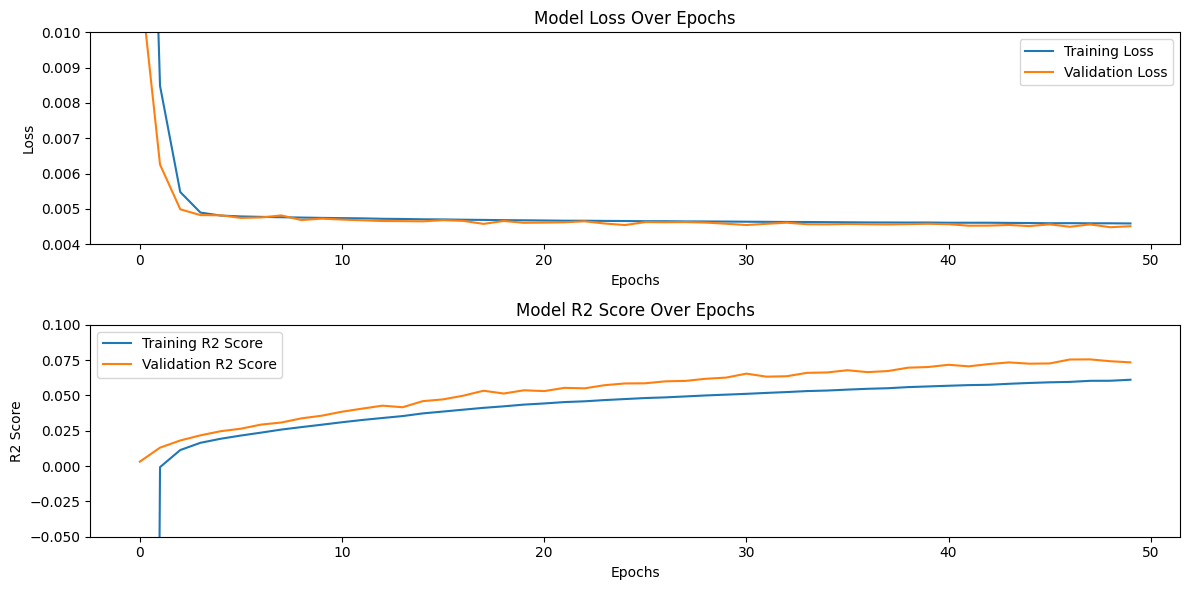

In [11]:
# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 6 ))

# Plotting Loss
axs[0].plot(Train_rec['loss'], label='Training Loss')
axs[0].plot(Train_rec['val_loss'], label='Validation Loss')
axs[0].set_ylim([0.004,0.01])
axs[0].set_title('Model Loss Over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plotting R2 Score
axs[1].plot(Train_rec['r2_score'], label='Training R2 Score')
axs[1].plot(Train_rec['val_r2_score'], label='Validation R2 Score')
axs[1].set_ylim([-0.05,0.1])
axs[1].set_title('Model R2 Score Over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('R2 Score')
axs[1].legend()
# Adjust layout to avoid overlap
plt.tight_layout()

# Display the combined figure
plt.show()

# Notes:
# - This code creates a visualization of the model's performance during training
# - It uses matplotlib to create two subplots: one for Loss and one for R2 Score
# - The figure size is set to 12x6 inches for better visibility
# - For the Loss plot:
#   * Training and Validation Loss are plotted over epochs
#   * Y-axis is limited to [0.004, 0.01] for focused view on relevant loss range
# - For the R2 Score plot:
#   * Training and Validation R2 Scores are plotted over epochs
#   * Y-axis is limited to [-0.05, 0.1] to highlight the relevant score range
# - Both plots include proper labeling (title, x-label, y-label) and legends
# - plt.tight_layout() is used to prevent overlap between subplots
# - plt.show() displays the final figure

# Thanks for using this visualization code! It provides a clear view of your model's training progress.
# You can adjust the y-axis limits (set_ylim) if needed to better suit your specific training results.

In [ ]:
T.iter_model()
iter_rec = T.iter_record

# Notes:
# - This code calls the iter_model() method on the T object, which likely performs iterative model training
# - The result of the iterative training is stored in T.iter_record
# - We then assign T.iter_record to the variable iter_rec for further use
# - This process allows us to capture the results of multiple iterations of model training
# - The iter_rec variable will likely contain information about model performance across iterations
# - This data can be used for analysis, visualization, or further processing of the model's iterative performance

In [20]:
def plot_score_vs_time(iter_record):
    # Extract time and score from the iter_record
    timestamps = [record['timestamp'] for record in iter_record]
    scores = [record['metric_score'] for record in iter_record]

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(timestamps, scores, marker='o', linestyle='-', color='b')
    
    # Set the title and labels
    plt.title('Metric Score vs. Time')
    plt.ylim([-0.1,0.1])
    plt.ylabel('Metric Score')

    # Show the plot
    plt.grid(True)
    plt.show()

# Notes:
# - This function visualizes the metric score over time for iterative model training
# - It takes 'iter_record' as input, which likely contains timestamps and metric scores
# - The function extracts timestamps and scores from the input data
# - It creates a line plot with markers using matplotlib
# - The plot is configured with a specific figure size (12x6 inches)
# - Y-axis limits are set to [-0.1, 0.1] to focus on relevant score range
# - The plot includes a title, y-axis label, and grid for better readability
# - This visualization helps in understanding how the model's performance changes over time
# - You may need to adjust the y-axis limits if your scores fall outside the [-0.1, 0.1] range

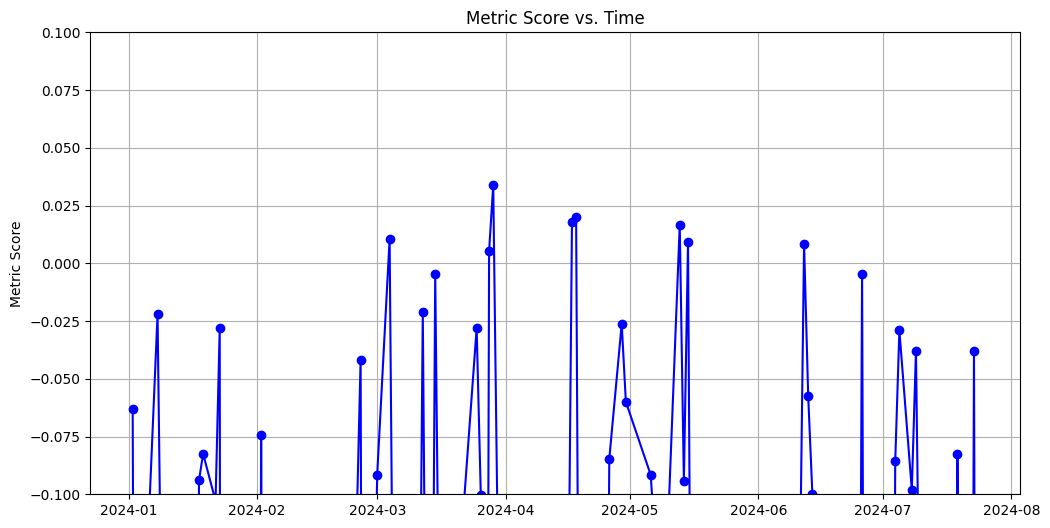

In [21]:
plot_score_vs_time(iter_rec)

In [15]:
def plot_prediction_summary_metrics(iter_record):
    # Initialize lists to store each metric
    mean_errors = []
    max_errors = []
    min_errors = []
    std_errors = []
    timestamps = [record['timestamp'] for record in iter_record]

    # Extract the summary metrics
    for record in iter_record:
        summary = record['prediction_summary']
        mean_errors.append(summary['mean_error'])
        max_errors.append(summary['max_error'])
        min_errors.append(summary['min_error'])
        std_errors.append(summary['std_error'])

    # Create the plot
    plt.figure(figsize=(12, 6))
    
    # Plot each metric
    plt.plot(timestamps, mean_errors, marker='o', linestyle='-', label='Mean Error')
    plt.plot(timestamps, max_errors, marker='o', linestyle='-', label='Max Error')
    plt.plot(timestamps, min_errors, marker='o', linestyle='-', label='Min Error')
    plt.plot(timestamps, std_errors, marker='o', linestyle='-', label='Std Error')

    # Set the title and labels
    plt.title('Prediction Summary Metrics vs. Time')
    plt.xlabel('Time')
    plt.ylabel('Error Metrics')

    # Add a legend to identify each line
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()

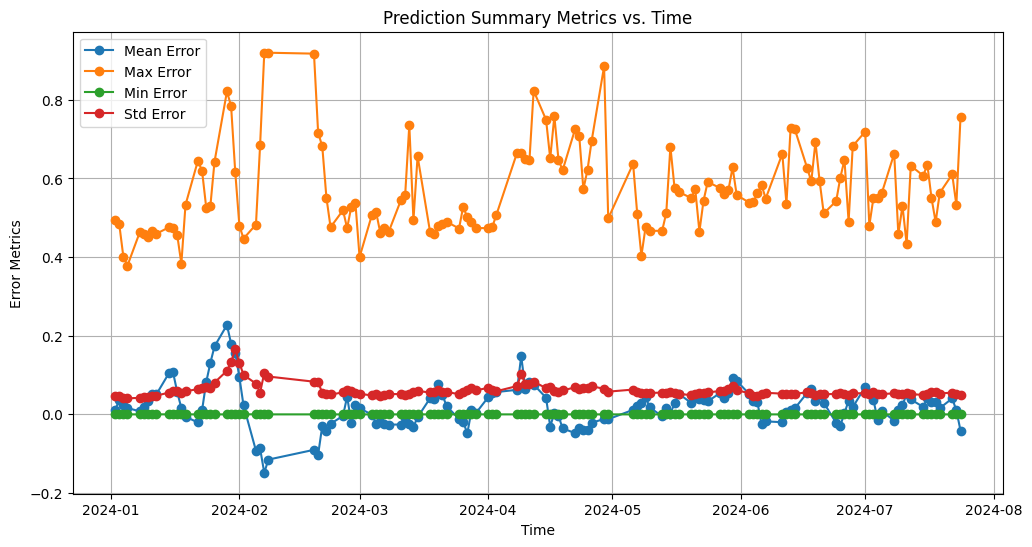

In [16]:
# Plot prediction summary metrics
# This function visualizes various error metrics over time
plot_prediction_summary_metrics(iter_rec)

In [21]:
# Function to analyze top and tail stocks performance
def analyze_top_tail_stocks(iter_record, x=10):
    # Initialize lists for storing metrics
    timestamps = [record['timestamp'] for record in iter_record]
    top_accuracy, tail_accuracy = [], []
    top_avg_returns, tail_avg_returns = [], []
    top_cumulative_returns, tail_cumulative_returns = [], []
    conditional_top_cum_returns, conditional_tail_cum_returns = [], []

    # Initialize counters for total accuracy
    total_top_correct_predictions = 0
    total_tail_correct_predictions = 0
    total_predictions = len(iter_record) * x

    # Initialize cumulative returns
    top_cumulative_return = 0
    tail_cumulative_return = 0
    conditional_top_cumulative_return = 0
    conditional_tail_cumulative_return = 0

    # Iterate through records to calculate metrics
    for i, record in enumerate(iter_record):
        df = record['results']

        # Sort stocks by prediction
        df_sorted = df.sort_values(by='Prediction', ascending=False)
        top_stocks = df_sorted.head(x)
        tail_stocks = df_sorted.tail(x)

        # Calculate accuracy
        top_correct_predictions = (top_stocks['Prediction'] * top_stocks['True'] > 0).sum()
        tail_correct_predictions = (tail_stocks['Prediction'] * tail_stocks['True'] > 0).sum()

        top_acc = top_correct_predictions / x
        tail_acc = tail_correct_predictions / x

        top_accuracy.append(top_acc)
        tail_accuracy.append(tail_acc)

        # Update total correct predictions
        total_top_correct_predictions += top_correct_predictions
        total_tail_correct_predictions += tail_correct_predictions

        # Calculate average returns
        top_avg_return = top_stocks['True'].mean()
        tail_avg_return = tail_stocks['True'].mean() * -1  # Negative for shorted stocks
        top_avg_returns.append(top_avg_return)
        tail_avg_returns.append(tail_avg_return)

        # Update cumulative returns
        top_cumulative_return += top_avg_return
        tail_cumulative_return += tail_avg_return
        top_cumulative_returns.append(top_cumulative_return)
        tail_cumulative_returns.append(tail_cumulative_return)

        # Calculate conditional cumulative returns
        if i >= 2:
            if top_accuracy[-1] > top_accuracy[-2]:
                conditional_top_cumulative_return += top_avg_return
            if tail_accuracy[-1] > tail_accuracy[-2]:
                conditional_tail_cumulative_return += tail_avg_return

        conditional_top_cum_returns.append(conditional_top_cumulative_return)
        conditional_tail_cum_returns.append(conditional_tail_cumulative_return)

    # Calculate total accuracy ratios
    total_top_accuracy_ratio = total_top_correct_predictions / total_predictions
    total_tail_accuracy_ratio = total_tail_correct_predictions / total_predictions

    # Create plots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 14))

    # Plot accuracy
    ax1.plot(timestamps, top_accuracy, marker='o', linestyle='-', color='g', label=f'Top {x} Accuracy')
    ax1.plot(timestamps, tail_accuracy, marker='o', linestyle='-', color='r', label=f'Tail {x} Accuracy')
    ax1.text(0.01, 0.95, f'Total Top {x} Accuracy: {total_top_accuracy_ratio:.2%}', transform=ax1.transAxes, fontsize=12, color='g')
    ax1.text(0.01, 0.90, f'Total Tail {x} Accuracy: {total_tail_accuracy_ratio:.2%}', transform=ax1.transAxes, fontsize=12, color='r')
    ax1.set_title('Top and Tail Stocks Accuracy')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot cumulative returns
    ax2.plot(timestamps, top_cumulative_returns, marker='o', linestyle='-', color='b', label=f'Top {x} Cumulative Return')
    ax2.plot(timestamps, tail_cumulative_returns, marker='o', linestyle='-', color='orange', label=f'Tail {x} Cumulative Return (Shorted)')
    ax2.plot(timestamps, conditional_top_cum_returns, marker='o', linestyle='--', color='purple', label=f'Conditional Top {x} Cumulative Return')
    ax2.plot(timestamps, conditional_tail_cum_returns, marker='o', linestyle='--', color='brown', label=f'Conditional Tail {x} Cumulative Return (Shorted)')
    ax2.set_title('Top and Tail Stocks Cumulative Returns')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Cumulative Return')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()
# Usage
# analyze_top_tail_stocks(your_iter_record, x=10)

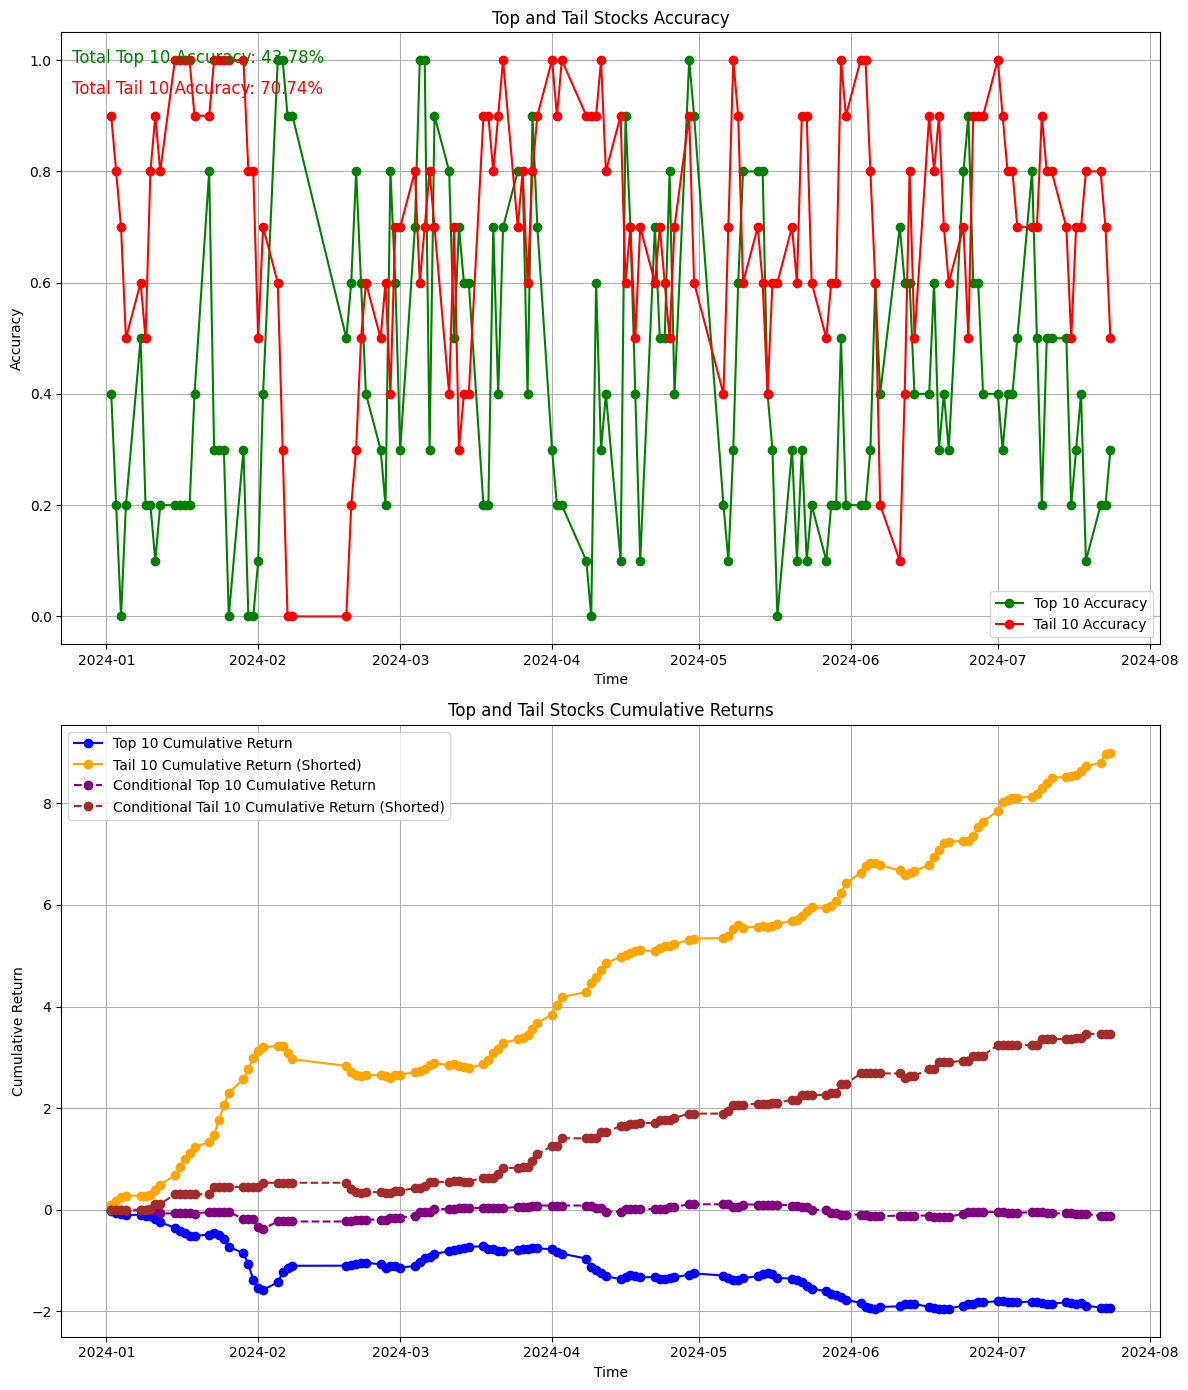

In [26]:
# Analyze top and tail stocks performance
# This function will plot accuracy and cumulative returns for top and bottom 10 stocks
# iter_rec: iteration record containing prediction results
# 10: number of top/tail stocks to analyze
analyze_top_tail_stocks(iter_rec, 10)